# Simulazione Real Environment 

## Drive & Environment Setting

In [1]:
IN_COLAB = False

try:
  import google.colab
  IN_COLAB = True
except:
  pass

if IN_COLAB == True:
  from google.colab import drive
  drive.mount('/content/gdrive')
  %cd /content/gdrive/MyDrive/Tesi_GDrive
  PROJECT_PATH = '/content/gdrive/MyDrive/Tesi_GDrive'
  #!ls
else:
  %cd /Users/edoardorossi/Documents/Universita/Tesi/Tesi_GDrive
  PROJECT_PATH = '/Users/edoardorossi/Documents/Universita/Tesi/Tesi_GDrive'

import warnings
import pickle
import sys
import os

if IN_COLAB == True:
  sys.path.insert(0, os.path.abspath('functions'))
  sys.path.insert(0, os.path.abspath(''))
else:
  sys.path.insert(0, os.path.abspath('functions'))
  sys.path.insert(0, os.path.abspath(''))

warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from keras.models import Sequential, Model
from keras.layers import Dense, Lambda
from keras.layers import Activation
from keras.activations import exponential, relu
from keras import backend as K
import tensorflow as tf
from tensorflow.keras.layers import Input, Layer, InputSpec, Reshape
from tensorflow.keras import initializers
from tensorflow.keras.optimizers import Adam
tf.config.run_functions_eagerly(True)
from scipy.optimize import minimize, differential_evolution

from pkl import store_data, load_data
from functions.compressor import compress
from functions.compressor_param import compress_2


import random
from collections import defaultdict

import time



print("Libraries imported")

/Users/edoardorossi/Documents/Universita/Tesi/Tesi_GDrive


2023-05-12 17:56:58.336114: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Libraries imported


## Import Anagrafica & CTA

In [2]:
cta30_def_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_def.csv')
CTA30_def = [cta30_def_path]
  
df_def = pd.read_csv(CTA30_def[0])

cta30_18_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_2018.csv')
cta30_19_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_2019.csv')
cta30_20_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_2020.csv')
cta30_21_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_2021.csv')
cta30_22_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_2022.csv')
CTA30_18 = [cta30_18_path]
CTA30_19 = [cta30_19_path]
CTA30_20 = [cta30_20_path]
CTA30_21 = [cta30_21_path]
CTA30_22 = [cta30_22_path]

df18= pd.read_csv(CTA30_18[0])
df19= pd.read_csv(CTA30_19[0])
df20= pd.read_csv(CTA30_20[0])
df21= pd.read_csv(CTA30_21[0])
df22= pd.read_csv(CTA30_22[0])
df = pd.concat([df18, df19, df20, df21, df22], ignore_index=True)

df['VLV_RAF_REG_00'] = df['VLV_RAF_REG_00'] / 100
df['VLV_SUR_REG_00'] = df['VLV_SUR_REG_00'] / 100

scaler = MinMaxScaler()
act_f_m = df.loc[:,'F_M_FDBK_00']
a_f_m_reshaped = np.array(act_f_m).reshape(-1, 1)
a_f_m_scaled = scaler.fit_transform(a_f_m_reshaped)

min_f = np.min(a_f_m_scaled)
max_f = np.max(a_f_m_scaled)

a_raf_df = df['VLV_RAF_REG_00'] * 0.5
a_sur_df = df['VLV_SUR_REG_00'] * 0.5 + 0.5

a_df = pd.concat([a_raf_df, a_sur_df], ignore_index=True)

pca_df = compress_2(df, 0.93)
print("df18 shape: ", df18.shape)
print("df19 shape: ", df19.shape)
[r,c] = df.shape
print("df shape: ", df.shape)
[r,n_components] = pca_df.shape
print("pca_df shape: ", pca_df.shape)

df18 shape:  (141811, 76)
df19 shape:  (523489, 76)
df shape:  (2176378, 76)
pca_df shape:  (2176378, 9)


## Clustering

In [3]:
n_cluster = 8
kmeans = KMeans(n_clusters=n_cluster, random_state=42)
X = pca_df
kms_df_fit = kmeans.fit(X)

kms_df = kmeans.predict(X)

In [4]:
labels = kmeans.labels_
cluster_sizes = pd.Series(labels).value_counts()
print(cluster_sizes)
df['Cluster'] = labels
pca_df['Cluster'] = labels


2    759189
3    250342
0    246413
1    226527
4    224119
6    177952
7    160348
5    131488
dtype: int64


La matrice di transizione P: n_cluster x a1 x a2 x a3. 

In [5]:
def find_nearest_index(numbers, value):
    nearest = min(numbers, key=lambda x: abs(x - value))
    nearest_index = np.where(numbers == nearest)[0][0]#numbers.index(nearest)
    return nearest_index

In [6]:
df['a1_discrete'] = None
df['a2_discrete'] = None
df['a3_discrete'] = None

[S, features] = df.shape

n_a1 = 15
n_a2 = 9
n_a3 = 9
a1_intervals = np.linspace(df['F_M_FDBK_00'].min(), df['F_M_FDBK_00'].max(), num=n_a1)
a2_intervals = np.linspace(0, 1, num=n_a2)
a3_intervals = np.linspace(0, 1, num=n_a3)
print(a1_intervals)
print(a2_intervals)
print(a3_intervals)


for i in range(S):
    ret1 = find_nearest_index(a1_intervals, df.loc[i,'F_M_FDBK_00'])
    df.loc[i,'a1_discrete'] = ret1

    ret2 = find_nearest_index(a2_intervals, df.loc[i,'VLV_RAF_REG_00'])
    df.loc[i,'a2_discrete'] = ret2

    ret3 = find_nearest_index(a3_intervals, df.loc[i,'VLV_SUR_REG_00'])
    df.loc[i,'a3_discrete'] = ret3




[  0.           7.16708571  14.33417143  21.50125714  28.66834286
  35.83542857  43.00251429  50.1696      57.33668571  64.50377143
  71.67085714  78.83794286  86.00502857  93.17211429 100.3392    ]
[0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.   ]
[0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.   ]


In [7]:
# save new df on cvs as df_clustered_partitioned.csv
#df.to_csv(os.path.join(PROJECT_PATH, 'CTA30/DF_clean/df_clustered_partitioned.csv'), index=False)

## Import Clustered & Partitioned Dataset

### Matrice di transizione

In [8]:
cta30_final_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/df_clustered_partitioned.csv')
CTA30_final = [cta30_final_path]
df = pd.read_csv(CTA30_final[0])
print(df)

n_cluster = 8
n_a1 = 15
n_a2 = 9
n_a3 = 9




,ANTIGELO_ALARM_00,AUTOMAN_M_CMD_00,AUTOMAN_M_ST_00,AUTOMAN_R_CMD_00,AUTOMAN_R_ST_00,AUTOMAN_SERR_CMD_00,AUTOMAN_SERR_ST_00,AUTOMAN_ST_00,AUTOMAN_VLV_CMD_00,AUTOMAN_VLV_ST_00,...,VLV_SUR_REG_00,FILTER_ALRM_01,FILTER_ALRM_00,FILTER_ALRM_02,METER_M_DIAG_00,METER_R_DIAG_00,Cluster,a1_discrete,a2_discrete,a3_discrete
0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,14,0,0
1,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,14,0,0
2,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,14,0,0
3,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,14,0,0
4,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,14,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2176373,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
2176374,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
2176375,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
2176376,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0


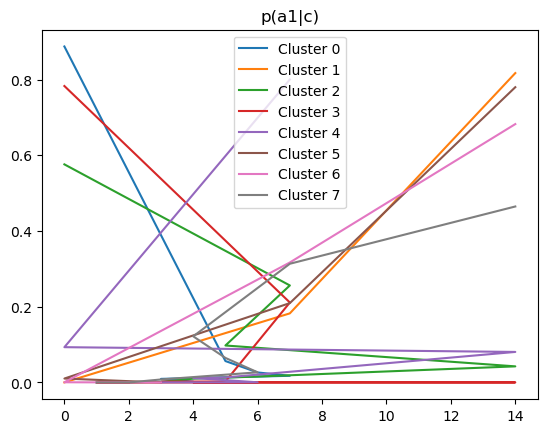

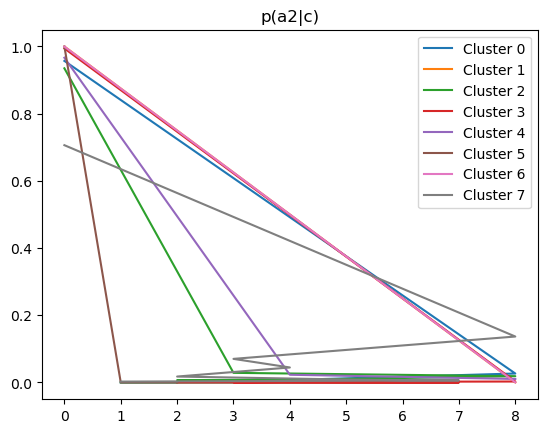

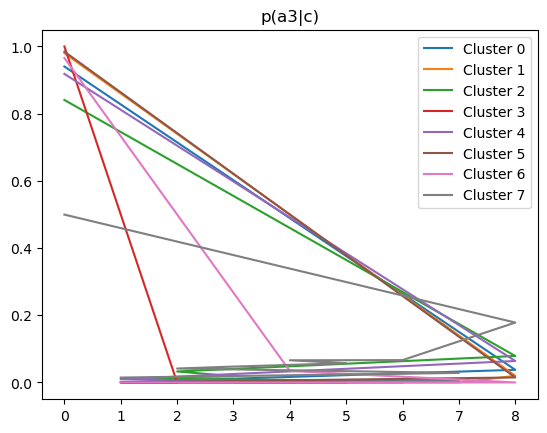

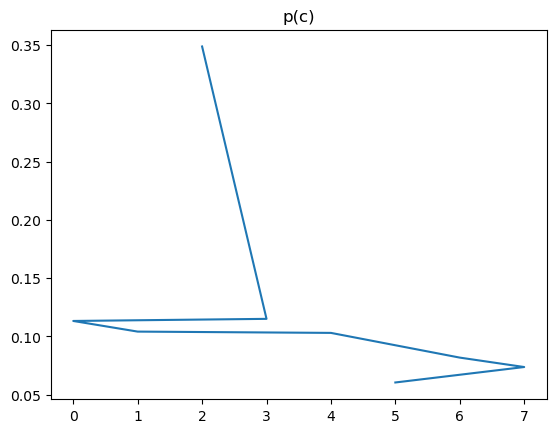

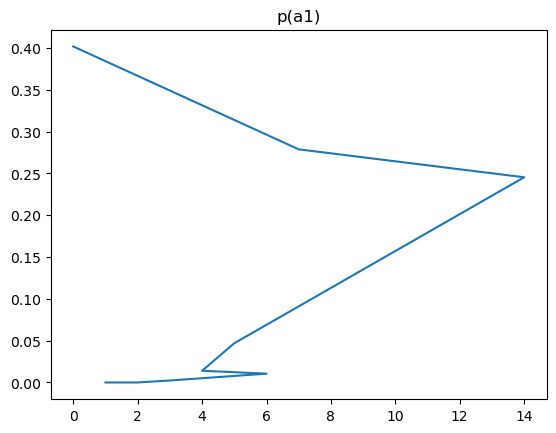

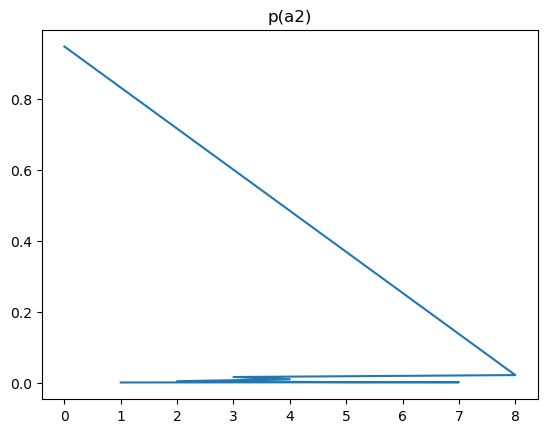

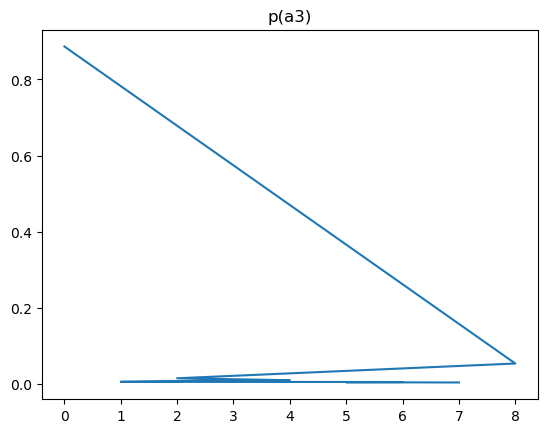

In [22]:
total_counts_a1 = []
for i in range(n_cluster):
    counts = df.loc[df['Cluster'] == i, 'a1_discrete'].value_counts()
    total_counts_a1.append([counts])

total_counts_a2 = []
for i in range(n_cluster):
    counts = df.loc[df['Cluster'] == i, 'a2_discrete'].value_counts()
    total_counts_a2.append([counts])

total_counts_a3 = []
for i in range(n_cluster):
    counts = df.loc[df['Cluster'] == i, 'a3_discrete'].value_counts()
    total_counts_a3.append([counts])

p_a1 = []
for i in range(n_cluster):
    p_a1.append(total_counts_a1[i][0] / total_counts_a1[i][0].sum())

p_a2 = []
for i in range(n_cluster):
    p_a2.append(total_counts_a2[i][0] / total_counts_a2[i][0].sum())

p_a3 = []
for i in range(n_cluster):
    p_a3.append(total_counts_a3[i][0] / total_counts_a3[i][0].sum())

#plot p(a1|c)
for i in range(n_cluster):
    plt.plot(p_a1[i], label='Cluster '+str(i))
plt.legend()
plt.title('p(a1|c)')
plt.show()

#plot p(a2|c)
for i in range(n_cluster):
    plt.plot(p_a2[i], label='Cluster '+str(i))
plt.legend()
plt.title('p(a2|c)')
plt.show()

#plot p(a3|c)
for i in range(n_cluster):
    plt.plot(p_a3[i], label='Cluster '+str(i))
plt.legend()
plt.title('p(a3|c)')
plt.show()

#plot p(c)
p_c = df['Cluster'].value_counts() / df['Cluster'].value_counts().sum()
plt.plot(p_c)
plt.title('p(c)')
plt.show()

#plot p(a1)
p_a1 = df['a1_discrete'].value_counts() / df['a1_discrete'].value_counts().sum()
plt.plot(p_a1)
plt.title('p(a1)')
plt.show()

#plot p(a2)
p_a2 = df['a2_discrete'].value_counts() / df['a2_discrete'].value_counts().sum()
plt.plot(p_a2)
plt.title('p(a2)')
plt.show()

#plot p(a3)
p_a3 = df['a3_discrete'].value_counts() / df['a3_discrete'].value_counts().sum()
plt.plot(p_a3)
plt.title('p(a3)')
plt.show()






In [27]:
print(p_c)
p_c[0]

2    0.348831
3    0.115027
0    0.113222
1    0.104084
4    0.102978
6    0.081765
7    0.073677
5    0.060416
Name: Cluster, dtype: float64


0.11322160029186107

In [33]:
T = np.zeros((n_cluster, n_cluster, n_a1, n_a2, n_a3))

for i1 in range(n_cluster):
    for i2 in range(n_cluster):
        for i3 in range(n_a1):
            for i4 in range(n_a2):
                for i5 in range(n_a3):
                    T[i1,i2,i3,i4,i5] =  0#p_c[i1] * p_c[i2] * p_a1[i3] * p_a2[i4] * p_a3[i5]


In [38]:

R = np.zeros((n_cluster, n_a1, n_a2, n_a3))

for i1 in range(n_cluster):
    for i2 in range(n_a1):
        for i3 in range(n_a2):
            for i4 in range(n_a3):
                R[i1,i2,i3,i4] = -df.loc['PW_ATT_M_00']

KeyError: 'PW_ATT_M_00'

In [36]:
df['PW_ATT_M_00']

0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
          ... 
2176373    0.0
2176374    0.0
2176375    0.0
2176376    0.0
2176377    0.0
Name: PW_ATT_M_00, Length: 2176378, dtype: float64

In [37]:
df['a2_discrete'].value_counts()

0    2060294
8      45868
3      34100
4      20656
2       8256
5       2557
7       2072
6       1997
1        578
Name: a2_discrete, dtype: int64

In [18]:
df.iloc[800000,:]

ANTIGELO_ALARM_00    0.0
AUTOMAN_M_CMD_00     1.0
AUTOMAN_M_ST_00      1.0
AUTOMAN_R_CMD_00     1.0
AUTOMAN_R_ST_00      1.0
                    ... 
FILTER_ALRM_00       0.0
FILTER_ALRM_02       0.0
METER_M_DIAG_00      0.0
METER_R_DIAG_00      0.0
Cluster              4.0
Name: 800000, Length: 77, dtype: float64

In [44]:
counts = df['F_M_FDBK_00'].value_counts
print(counts)


<bound method IndexOpsMixin.value_counts of 0          99.9998
1         100.0128
2          99.9898
3         100.0072
4          99.9782
            ...   
665295     50.0169
665296     50.0213
665297     50.0296
665298     50.0241
665299     50.0071
Name: F_M_FDBK_00, Length: 665300, dtype: float64>


AttributeError: 'function' object has no attribute 'plt'

In [34]:
# generate a df for each cluster
cluster_dfs = []
for i in range(n_cluster):
    cluster_df = df[df['Cluster'] == i]
    cluster_dfs.append(cluster_df)
    